In [1]:
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from numpy.random import seed
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Dense,
    Dropout,
    Input,
    RepeatVector,
    TimeDistributed,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

warnings.simplefilter(action="ignore")
seed(1)

In [2]:
url = "https://raw.githubusercontent.com/hnunezd/DSI/main/real_26.csv"
df = pd.read_csv(url)

,timestamp,value,is_anomaly
0,1,1,0
1,2,94,0
2,3,82,0
3,4,92,0
4,5,104,0


In [3]:
df1 = pd.DataFrame(df["value"])

In [6]:
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(df1)

In [7]:
gdp_decomp = df1.copy()
gdp_decomp["cycle"] = gdp_cycle
gdp_decomp["trend"] = gdp_trend

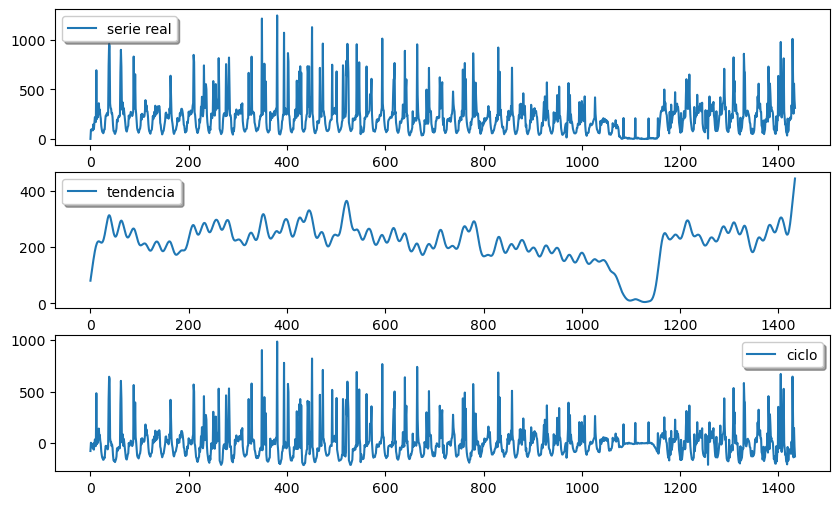

In [8]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(gdp_decomp["value"], label="serie real")
plt.legend(shadow=True)
plt.subplot(3, 1, 2)
plt.plot(gdp_decomp["trend"], label="tendencia")
plt.legend(shadow=True)
plt.subplot(3, 1, 3)
plt.plot(gdp_decomp["cycle"], label="ciclo")
plt.legend(shadow=True)
# plt.savefig("/Users/hn/OneDrive/Doctorado/Tesis/Proyecto Tesis/fig_examen/hp_filter26.pdf")
plt.show()

In [11]:
values = gdp_decomp.loc[:, "trend"]
target = df["is_anomaly"]

In [12]:
test = int(len(df) * 0.5)

In [13]:
x_train = values[:test].values
x_test = values[test : len(df)].values

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_p = scaler.fit_transform(x_train.reshape(-1, 1))

In [15]:
scaled_test = scaler.fit_transform(x_test.reshape(-1, 1))

In [16]:
x_train_p, y_train_p = [], []
for i in range(8, len(scaled_data_p)):
    x_train_p.append(scaled_data_p[i - 8 : i])
    y_train_p.append(scaled_data_p[i])
x_train_p, y_train_p = np.array(x_train_p), np.array(y_train_p)

In [17]:
x_test_p, y_test_p = [], []
for i in range(8, len(scaled_test)):
    x_test_p.append(scaled_test[i - 8 : i])
    y_test_p.append(scaled_test[i])
x_test_p, y_test_p = np.array(x_test_p), np.array(y_test_p)

In [18]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(64, input_shape=(8, 1), return_sequences=True))
model_lstm.add(tf.keras.layers.ReLU())
model_lstm.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.15, return_sequences=True))
model_lstm.add(tf.keras.layers.ReLU())
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.LSTM(16, recurrent_dropout=0.15, return_sequences=False))
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(1))

In [19]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 64)             16896     
                                                                 
 re_lu (ReLU)                (None, 8, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 8, 32)             12416     
                                                                 
 re_lu_1 (ReLU)              (None, 8, 32)             0         
                                                                 
 dropout (Dropout)           (None, 8, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [ ]:
tf.random.set_seed(123)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)

model_lstm.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.metrics.MeanAbsoluteError()],
)

history = model_lstm.fit(
    x_train_p,
    y_train_p,
    validation_split=0.2,
    batch_size=100,
    shuffle=False,
    epochs=200,
    callbacks=[early_stopping],
)

In [21]:
predictions_lstm = model_lstm.predict(x_test_p)

23/23 [==============================] - 1s 5ms/step


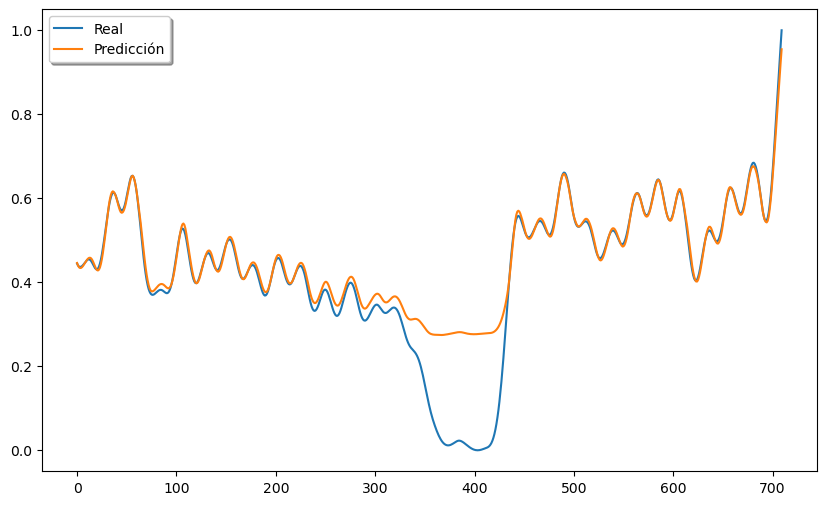

In [22]:
plt.figure(figsize=(10, 6))
# plt.xlim(1900,2100)
plt.plot(y_test_p, label="Real")
plt.plot(predictions_lstm, label="Predicción")
plt.legend(shadow=True)
plt.show()

In [59]:
df_1 = pd.DataFrame()

In [60]:
df_1["real"] = pd.DataFrame(y_test_p)

In [61]:
df_1["pred"] = predictions_lstm

In [62]:
df_1["anomaly"] = target[test + 8 : len(df)].values

In [63]:
df_1["Error"] = (df_1.real - df_1.pred) ** 2

In [64]:
anom = df_1[df_1["anomaly"] == 1]

In [65]:
df_1["score"] = (df_1["Error"] - np.min(df_1.Error)) / (
    np.max(df_1.Error) - np.min(df_1.Error)
)

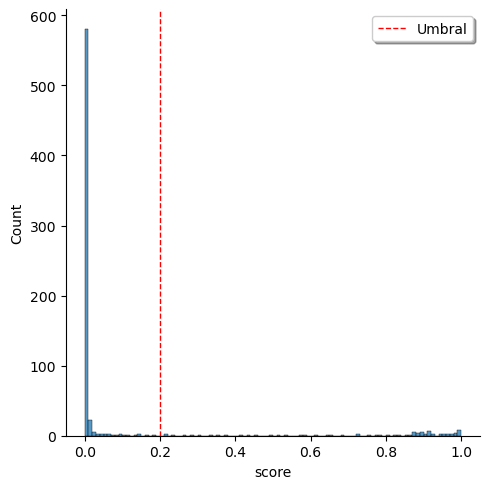

In [66]:
sns.displot(data=df_1, x="score", bins=100)
plt.axvline(0.2, color="red", linewidth=1, linestyle="dashed", label="Umbral")
plt.legend(shadow=True)
# plt.savefig("/Users/hn/OneDrive/Doctorado/Tesis/Proyecto Tesis/fig_examen/lstm_umbral_1.pdf")
plt.show()

In [67]:
umbral = 0.2

In [68]:
df_1["pred_score"] = np.where(df_1.score > umbral, 1, 0)

In [69]:
df_1[df_1["pred_score"] == 1]

,real,pred,anomaly,Error,score,pred_score
349,0.167365,0.294388,0,0.016135,0.210734,1
350,0.155812,0.291002,0,0.018276,0.238699,1
351,0.144036,0.287767,0,0.020658,0.269812,1
352,0.132331,0.284805,0,0.023248,0.303639,1
353,0.120929,0.282186,1,0.026004,0.339626,1
...,...,...,...,...,...,...
424,0.095335,0.293917,1,0.039435,0.515049,1
425,0.115376,0.298404,1,0.033499,0.437522,1
426,0.137870,0.303770,1,0.027523,0.359466,1
427,0.162742,0.310158,1,0.021732,0.283830,1


In [72]:
anom_score = df_1[df_1["pred_score"] == 1]

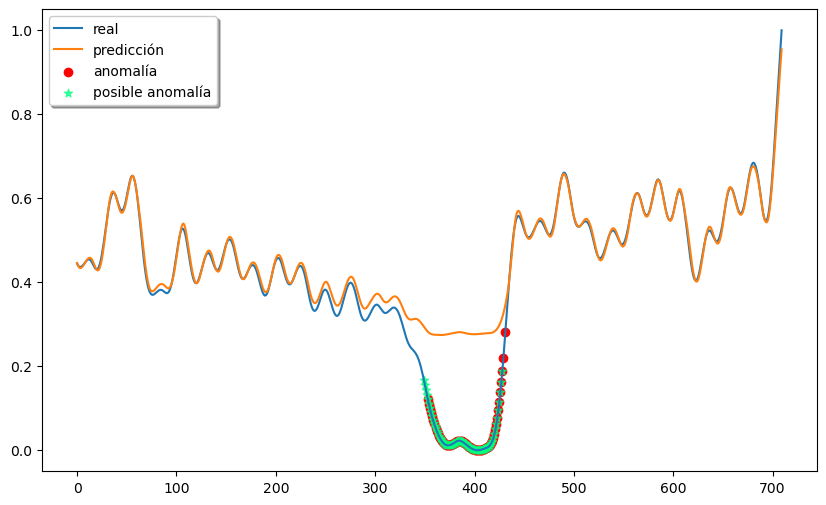

In [73]:
plt.figure(figsize=(10, 6))
# plt.xlim(1900,2100)
plt.plot(y_test_p, label="real")
plt.plot(predictions_lstm, label="predicción")
plt.scatter(anom.index, anom.real, c="red", label="anomalía")
plt.scatter(
    anom_score.index,
    anom_score.real,
    c="#00ff80",
    alpha=0.7,
    marker="*",
    label="posible anomalía",
)
plt.legend(shadow=True)
# plt.savefig("/Users/hn/OneDrive/Doctorado/Tesis/Proyecto Tesis/fig_examen/lstm_score26_trend.pdf")
plt.show()